# Mission **$\alpha$**

<div>
<img src="Images\Mission alpha\Mission alpha.jpg" width="500"/>
</div>

In this notebook, is divided in the following Sections:
1) Excitonic dimer
2) First exciton manifold
3) Dynamics of a TLS
4) Visualization of dynamics in the Bloch sphere

In parallel with the exploration of the aforementioned concepts, the aim of this notebook is to give you an overview on how we write scientific code for simulating the systems of interest.

For this reason, we will try to give as much examples as possible.

Now, we import some libraries

In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from qutip import sigmax, sigmaz, sigmay, tensor, identity
from qutip import Bloch, Qobj, basis, sesolve
from IPython.display import Image, display, Math

and define a function for matrix visualization in LaTeX

In [5]:
def array_to_latex(array, real = False):
    array = array.real if real else array
    matrix = ''
    for row in array:
        try:
            for number in row:
                matrix += f'{number}&'
        except TypeError:
            matrix += f'{row}&'
        matrix = matrix[:-1] + r'\\'
    display(Math(r'\begin{bmatrix}'+matrix+r'\end{bmatrix}'))

## 1. Excitonic dimer

We start by considering an excitonic dimer.

In a minimal model, each monomer can be described as a **Two-Level System** (TLS) with a ground $|g\rangle$ and excited $|e\rangle$ electronic states separated by a certain energy gap $E$ (or $\epsilon$).

To form an excitonic dimer, the two chromophores needs to interact each other.
The excitonic interaction strength will be denoted as $V$ (elsewhere $J$ is also used). 

When we describe the system "monomer-wise", i.e., when the basis set is composed of statevectors localized on each monomer, we call this basis set the **local** or **site basis**.

When we diagonalize the Hamiltonian, the resulting basis set is called the **exciton basis**.

A straightforward example of an excitonic dimer is the case of two interacting chromophores.

However, more exotic scenarios are possible.

For example, the Light-Harvesting 2 (LH2) complex is composed of two rings of chromophores.

The intra-ring interaction between chromophores is stronger than the interaction between one ring and the other (inter-ring).

This difference in the interaction strengths will cause a difference in the **timescales** of intra- and inter-ring quantum transport, with the first one being faster than the second.

Therefore, in a roughly approximation, the two rings of LH2 complex can be interpreted as two weakly interacting monomers.

In this case, the local basis is composed of the states localized on one of the two rings and delocalized over the ring itself.

<div>
<img src="Images\Mission alpha\Excitonic dimer.png" width="500"/>
</div>

The total Hamiltonian can be written as
$$H = H_1 + H_2 + H_{int}.$$

with $H_{1} = E_{1} | e_{1} \rangle\langle e_{1} |$, $H_{2} = E_{2} | e_{2} \rangle\langle e_{2} |$ and $H_{int} \propto V$.

However, a more formal writing takes in consideration the division of the two different Hilbert spaces.

We therefore can write

$$H = H_1 \otimes \mathbb{1}_2 + \mathbb{1}_1 \otimes H_2 +  V \left( | g_{1}e_{2} \rangle\langle e_{1}g_{2} | + | e_{1}g_{2} \rangle\langle g_{1}e_{2} | \right)$$
$$\left| \psi_1, \psi_2 \right\rangle = \left| \psi_1 \right\rangle \otimes \left| \psi_2 \right\rangle$$

or

$$H = \mathbb{1}_2 \otimes H_1 + H_2 \otimes \mathbb{1}_1 +  V \left( | g_{2}e_{1} \rangle\langle e_{2}g_{1} | + | e_{2}g_{1} \rangle\langle g_{2}e_{1} | \right)$$
$$\left| \psi_2, \psi_1 \right\rangle = \left| \psi_2 \right\rangle \otimes \left| \psi_1 \right\rangle$$

based on the desired ordering of the two sub-systems.

The first type of writing is usually more chemistry-friendly, while the second one is more quantum-computing-friendly (binary representation of a number: $1001 = 1\cdot2^3 + 0\cdot2^2 + 0\cdot2^1 + 1\cdot2^0$).

Below, we will use the first convention to report some example of how to write the Hamiltonian with parameters

In [6]:
E1 = 1.46    # Energy monomer 1
E2 = 1.55    # Energy monomer 2
V = 0.1      # Excitonic coupling

For low dimensional Hamiltonians, as in the case of a dimer, a simple way is to use lists and `numpy`

In [7]:
H = [[0, 0, 0, 0],
     [0, E2, V, 0],
     [0, V, E1, 0],
     [0, 0, 0, E1+E2]]
H = np.array(H)
array_to_latex(H)

<IPython.core.display.Math object>

Alternatively, we can use `qutip` as

In [8]:
H1 = E1 / 2 * tensor(identity(2)-sigmaz(),
                     identity(2)
                    )
H2 = E2 / 2 * tensor(identity(2),
                     identity(2)-sigmaz()
                    )
H_int = V / 2 * (tensor(sigmax(),
                        sigmax(),
                       ) \
                 + \
                 tensor(sigmay(),
                        sigmay(),
                       )
                )
H = (H1 + H2 + H_int).full()
array_to_latex(H, real=True)

<IPython.core.display.Math object>

This requires some more code, but it can be easily programmed for larger systems.

For example, see the following implementation (note that other implementations with better scaling are possible)

In [9]:
N = 5
E = 1.5 + np.random.randn(N)*0.1
V = 0.1
H = np.zeros((2**N, 2**N), dtype='complex')
for i in range(N):
    H_i = E[i]/2 * (tensor(identity(2**i),
                           identity(2)-sigmaz(),
                           identity(2**(N-i-1))
                          )
                   )
    H += H_i.full()
    for j in range(i+1, N):
        H_ij = V/2 * (tensor(identity(2**i),
                             sigmax(),
                             identity(2**(j-i-1)),
                             sigmax(),
                             identity(2**(N-j-1))
                            ) \
                      + \
                      tensor(identity(2**i),
                             sigmay(),
                             identity(2**(j-i-1)),
                             sigmay(),
                             identity(2**(N-j-1))
                            )
                     )
        H += H_ij.full()
array_to_latex(H, real=True)

<IPython.core.display.Math object>

## 2. First excitation manifold

Often, when studying exciton transport in molecular networks, the relevant Hilbert space is restricted around the **first excitation manifold**.

In fact, under perturbative coupling with an electric field the second exciton manifold is poorly populated, while the relaxation process to the ground state is usually slower than transport in the first excition manifold.

<div>
<img src="Images\Mission alpha\Excitonic dimer TLS.png" width="500"/>
</div>

In [10]:
def Hamiltonian_TLS(E1, E2, V):
    H = np.array([[E1, V],
                  [V, E2]])
    return H

array_to_latex(Hamiltonian_TLS(E1, E2, V))

<IPython.core.display.Math object>

Note that this reduced Hamiltonian correspond to the central block of the complete dimer Hamiltonian in the "quantum-computing-friendly" mapping.

The eigenvalues of the Two-Level System (TLS) are very well-known to be
$$E_\pm = \frac{ E_1 + E_2 \pm \sqrt{4 V^2 + \Delta E^2}}{2}$$
where $\Delta E = {E_1 - E_2}$.

Note that $\frac{E_1 + E_2}{2}$ is just an energy shift and the system Hamiltonian can be redefined in order to have it equal to zero: $H' = H - \frac{E_1 + E_2}{2} \mathbb{1}$.

<IPython.core.display.Javascript object>


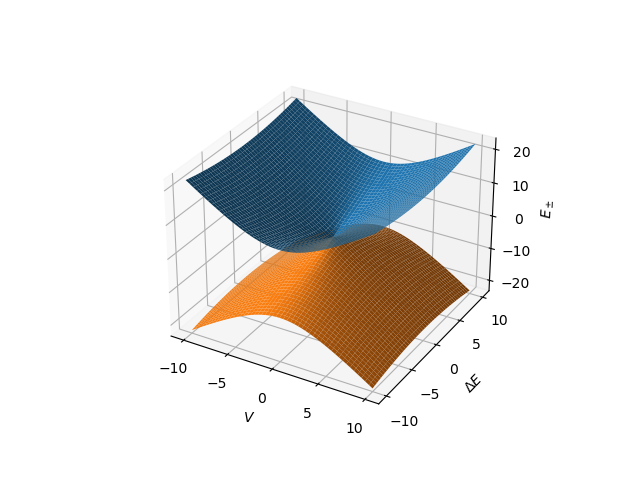

In [11]:
V_list = np.arange(-10, 10, 0.01)
Delta_E_list = np.arange(-10, 10, 0.01)
V_mesh, DE_mesh = np.meshgrid(V_list, Delta_E_list, indexing='xy')
Eigenvector_p = np.sqrt(4*V_mesh**2 + DE_mesh**2)
Eigenvector_m = - np.sqrt(4*V_mesh**2 + DE_mesh**2)

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(V_mesh, DE_mesh, Eigenvector_p);
ax.plot_surface(V_mesh, DE_mesh, Eigenvector_m);
ax.set_xlabel(r'$V$'); ax.set_ylabel(r'$\Delta E$'); ax.set_zlabel(r'$E_\pm$');

## 3. Dynamics of a TLS

Here, we will see some dynamical aspects along with computational methods for the simulation of time-independent Schrödinger dynamics.

Remember:

- `exp` and `expm` applied to non-diagonal matrices returns different outcomes. `exp(A)` is an element-wise operation, `expm(A)` acts on the whole matrix.
- Hermitian matrices: $A = A^\dagger$.
- Physical Hamiltonians $H$ are Hermitian.
- Unitary matrices: $A^\dagger A = A A^\dagger = A A^{-1} = \mathbb{1}$ (so for square matrices $A^{-1} = A^\dagger$). Unitary matrix corresponds to rotations and reflections in the Hilbert space. They do not distort the Hilbert space, i.e., they preserve the length of a statevector.
- The eigenvector matrix $W$ of a Hermitian Hamiltonian $H$ is unitary.
- The propagator $U$ associated with a Hermitian Hamiltonian $H$ is unitary.

First, we will see two methods based on the direct exponentialization of the Hamiltonian.

In [12]:
def Schrodinger_expm(psi: np.ndarray,
                     H: np.ndarray,
                     t_list: np.ndarray | list):
    '''
    Schrodinger evolution of a pure state using the matrix exponential function.
    
    Parameters
    ----------
    psi: numpy.ndarray
        The initial state of the system given as a statevector.
    
    H: numpy.ndarray
        The time-independent Hamiltonian of the system.
        
    t_list: numpy.ndarray | list
        The array containing the delay times at which the state of the system must be calculated.
        The list is assumed to be equally spaced, i.e., there is a constant time step.
    
    Returns
    -------
    psi_list: numpy.ndarray
        The state of the system during the dynamics.
    '''
    dt = t_list[1] - t_list[0]                                     # Get the time step from t_list
    U = expm(-1.j * H * dt)                                        # Create the propagator using numpy.expm
    psi_list = np.zeros((len(psi), len(t_list)), dtype=complex)    # Initialize the output container
    psi_list[:,0] = psi                                            # Apply the initial condition
    for n in range(1, len(t_list)):                                # For loop on the delay times != 0
        psi_list[:,n] = U @ psi_list[:,n-1]                        # Evolve the state for a time step
    
    return psi_list

In [13]:
def Schrodinger_diag_exp(psi, H, t_list):
    dt = t_list[1] - t_list[0]
    D, W = np.linalg.eigh(H)
    U = W @ np.diag(np.exp(-1.j * D * dt)) @ np.conj(W).T
    psi_list = np.zeros((len(psi), len(t_list)), dtype=complex)
    psi_list[:,0] = psi 
    for n in range(1, len(t_list)):
        psi_list[:,n] = U @ psi_list[:,n-1]
    
    return psi_list

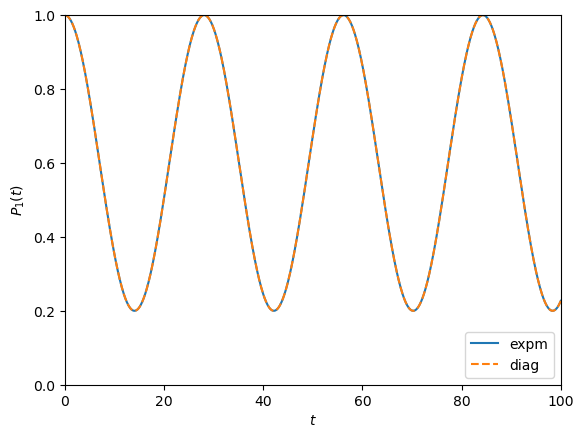

In [14]:
E1 = 0; E2 = 0.1; V = 0.1; H = Hamiltonian_TLS(E1, E2, V)
dt = 0.1

psi = np.array([1,0])
t_list = np.arange(0, 100+dt, dt)
psi_expm = Schrodinger_expm(psi, H, t_list)
psi_diag_exp = Schrodinger_diag_exp(psi, H, t_list)

%matplotlib inline
plt.plot(t_list, np.abs(psi_expm[0,:])**2);
plt.plot(t_list, np.abs(psi_diag_exp[0,:])**2, '--');
plt.legend(['expm', 'diag'], loc=4);
plt.xlabel(r'$t$'); plt.ylabel(r'$P_1(t)$');
plt.ylim(0,1); plt.xlim(min(t_list), max(t_list)); plt.rcParams["figure.figsize"] = (8,4); plt.rcParams["figure.dpi"] =100

Pros:
- Fast to write
- Small errors: truncation (both), approximation (`expm`)
- Unitary evolution (beyond truncation effects)

Cons:
- Scalability problems for large Hamiltonians

Now, we will see two well-known methods for propagation based on the expansion of the propagator.

In particular, the Euler method is a first order expansion
$$e^{-iHdt} \approx \mathbb{1} - iHdt$$

The forth-order Runge-Kutta method, for time-independent Hamiltonians, corresponds to the exponential expansion up to 4th order:
$$e^{-iHdt} \approx \mathbb{1} - iHdt - \frac{1}{2!}H^2dt^2 + \frac{i}{3!}H^3dt^3 + \frac{1}{4!}H^4dt^4$$


In [15]:
def Schrodinger_euler(psi, H, t_list):
    dt = t_list[1] - t_list[0]
    psi_list = np.zeros((len(psi), len(t_list)), dtype=complex)
    psi_list[:,0] = psi
    for n in range(1, len(t_list)):
        psi_list[:,n] = psi_list[:,n-1] - (1.j * H * dt) @ psi_list[:,n-1]
        # psi_list[:,n] /= np.sum(np.abs(psi_list[:,n])**2)        # Normalization of the state is wrong!!!
    
    return psi_list

In [16]:
def Schrodinger_RK4(psi, H, t_list):
    dt = t_list[1] - t_list[0]
    psi_list = np.zeros((len(psi), len(t_list)), dtype=complex)
    psi_list[:,0] = psi 
    for n in range(1, len(t_list)):
        k1 = -1.j * dt * H @ psi_list[:,n-1]
        k2 = -1.j * dt * H @ (psi_list[:,n-1] + 0.5 * k1)
        k3 = -1.j * dt * H @ (psi_list[:,n-1] + 0.5 * k2)
        k4 = -1.j * dt * H @ (psi_list[:,n-1] + k3)
        psi_list[:,n] = psi_list[:,n-1] + (k1 + 2 * k2 + 2 * k3 + k4)/ 6
        
    return psi_list

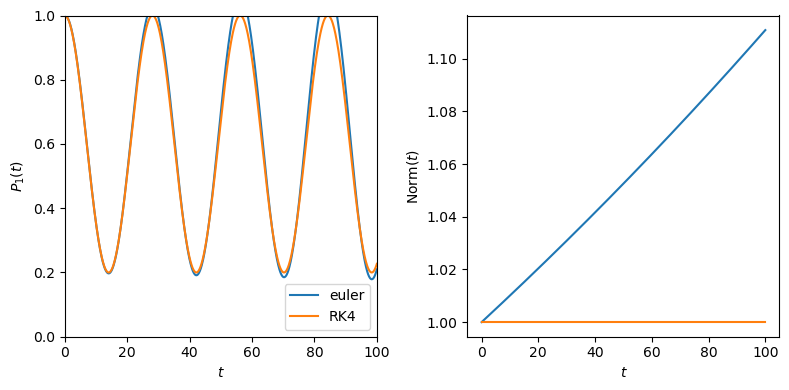

In [17]:
E1 = 0; E2 = 0.1; V = 0.1; H = Hamiltonian_TLS(E1, E2, V)
dt = 0.1                                                           # The choice of dt is important!!!
t_list = np.arange(0, 100+dt, dt)

psi_euler = Schrodinger_euler(psi, H, t_list)
psi_RK4 = Schrodinger_RK4(psi, H, t_list)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(t_list, np.abs(psi_euler[0,:])**2);
ax1.plot(t_list, np.abs(psi_RK4[0,:])**2);
ax1.legend(['euler', 'RK4', 'Trotter'], loc=4)
ax1.set_xlabel(r'$t$'); ax1.set_ylabel(r'$P_1(t)$');
ax1.set_ylim(0,1); ax1.set_xlim(min(t_list),max(t_list));
ax2.plot(t_list, np.sum(np.abs(psi_euler)**2, axis=0));
ax2.plot(t_list, np.sum(np.abs(psi_RK4)**2, axis=0));
ax2.set_xlabel(r'$t$'); ax2.set_ylabel(r'Norm$(t)$');
fig.tight_layout(); fig.set_size_inches(8,4); fig.set_dpi(100)

Pros:
- Do not require diagonalization or `expm`
- Fast run

Cons:
- Strictly dependent on $dt$: error accumulates at each time step
- Non-unitary

Given an Hamiltonian $H$ that can be written as the sum of simpler Hermitian matrices $H = \sum_{\alpha=1}^A H_\alpha$, the Trotter expansion (or first-order Trotter-Suzuki expansion) of the propagator is
$$e^{-iHt} = \lim_{n\to\infty} \left( \prod_{\alpha=1}^A e^{-iH_\alpha\frac{t}{n}} \right)^n.$$

The way to approximate and the relative error is
$$e^{-iHt} = \left( \prod_{\alpha=1}^A e^{-iH_\alpha \frac{t}{n}} \right)^n + \mathcal{O}\left( A^2 \frac{t^2}{n} \right) = \left( \prod_{\alpha=1}^A e^{-iH_\alpha dt} \right)^{\frac{t}{dt}} + \mathcal{O}\left( A^2 t dt \right)$$
where $dt=\frac{t}{n}$.

In [18]:
def Schrodinger_Trotter(psi, E1, E2, V, t_list):
    dt = t_list[1] - t_list[0]
    U = expm(- 1.j * V * sigmax().full() * dt)
    U = U @ expm(- 1.j * (E1-E2)/2 * sigmaz().full() * dt)
    psi_list = np.zeros((len(psi), len(t_list)), dtype=complex)
    psi_list[:,0] = psi 
    for n in range(1, len(t_list)):
        psi_list[:,n] = U @ psi_list[:,n-1]
    
    return psi_list

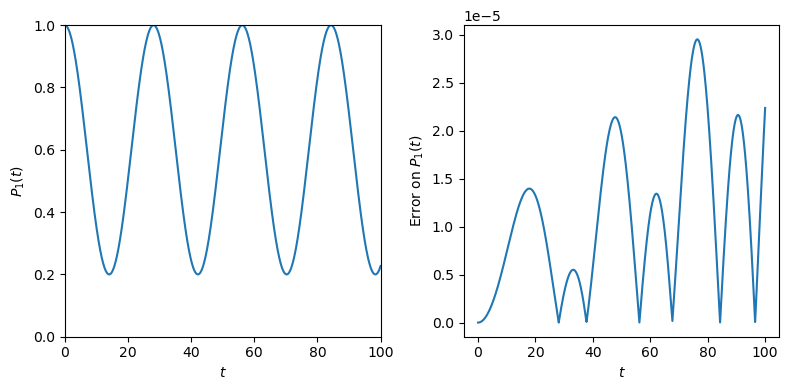

In [19]:
E1 = 0; E2 = 0.1; V = 0.1
dt = 0.1                                                           # The choice of dt is important!!!
t_list = np.arange(0, 100+dt, dt)

psi_Trotter = Schrodinger_Trotter(psi, E1, E2, V, t_list)
psi_expm = Schrodinger_expm(psi, Hamiltonian_TLS(E1, E2, V), t_list)
error = np.abs(np.abs(psi_Trotter[0,:])**2 - np.abs(psi_expm[0,:])**2)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(t_list, np.abs(psi_Trotter[0,:])**2);
ax1.set_xlabel(r'$t$'); ax1.set_ylabel(r'$P_1(t)$');
ax1.set_ylim(0,1); ax1.set_xlim(min(t_list),max(t_list));
ax2.plot(t_list, error);
ax2.set_xlabel(r'$t$'); ax2.set_ylabel(r'Error on $P_1(t)$');
fig.tight_layout(); fig.set_size_inches(8,4); fig.set_dpi(100)

Pros:
- Require to diagonalize or `expm` much simpler matrices
- Fast run
- Unitary evolution (beyond truncation effects)

Cons:
- Strictly dependent on $dt$: error accumulates at each time step
- Unitary (you don't see error accumulating on the norm)

## 4. Visualization of dynamics on the Bloch sphere

In this Section, we will visualize the dynamics of a TLS on the Bloch sphere.

The Bloch sphere is a very effective tool that gives a clear picture of what is happening to the state of a TLS.

<div>
<img src="Images\Mission alpha\Bloch Sphere.png" width="500"/>
</div>

After defining a certain basis set, on the north and south pole of the Bloch sphere, i.e., along the $\hat{z}$ axis, we find the states $|0\rangle$ and $|1\rangle$, respectively.

On the equator of the sphere there are the perfectly balanced superposition states.
Here the probability to find the two states is equal.

At the intersections with the $\hat{x}$ axis, there are the superposition states $|+\rangle$, where $|0\rangle$ and $|1\rangle$ has the same phase, and $|-\rangle$, where $|0\rangle$ and $|1\rangle$ have a relative phase difference $\phi = \pi$.

At the intersections with the $\hat{y}$ axis, there are the superposition states $|+i\rangle$ and $|-i\rangle$, where $|0\rangle$ and $|1\rangle$ have a relative phase difference $\phi = \pm\pi$.

In general,
$$ |\psi\rangle = cos \frac{\theta}{2} |0\rangle + e^{i\phi} sin \frac{\theta}{2} |1\rangle $$
where $\theta$ is the angle between the statevector and the $\hat{z}$.
Note that in the equation $\theta$ is divided by 2.
This is because in the block sphere states $|0\rangle$ and $|1\rangle$ are represented on the two poles, while in "reality" the are orthogonal.

In the following, we import some libraries useful to run the code below.

In [19]:
import imageio.v2 as imageio
from os import listdir
from os.path import isfile, join
import shutil

Let's visualize on the Bloch sphere the dynamics of our excitonic TLS on the **site basis**.

In green, we show the **precession** axis. This is dictated by the system Hamiltonian.

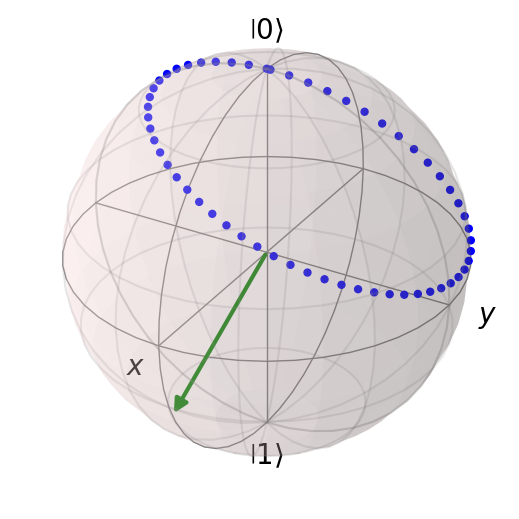

In [21]:
E1 = 0; E2 = 0.1; V = 0.1; H = Hamiltonian_TLS(E1, E2, V); dt = 0.5; t_list = np.arange(0, 28+dt, dt)
sphere = Bloch()
result = sesolve(Qobj(H), basis(2, 0), t_list, e_ops=[sigmax(), sigmay(), sigmaz()])
sx, sy, sz = result.expect[0], result.expect[1], result.expect[2]
sphere.add_points([sx, sy, sz])
sphere.add_vectors([V/np.sqrt(V**2+(E1-E2)**2/4), 0., (E1-E2)/2/np.sqrt(V**2+(E1-E2)**2/4)])
sphere.show()

If you want to produce an animated gif run the following code.

In [32]:
sphere = Bloch()
for i in range(len(sx)):
    sphere.clear()
    for j in range(i+1):
        sphere.add_points([sx[j], sy[j], sz[j]], alpha=np.exp((j-i)/15))
    sphere.add_vectors([V/np.sqrt(V**2+(E1-E2)**2/4), 0., (E1-E2)/2/np.sqrt(V**2+(E1-E2)**2/4)])
    sphere.point_color ='b'; sphere.point_marker = 'o'; sphere.point_size = [25]
    sphere.make_sphere()
    sphere.save(name='temp_site_bloch\eig_bloch_{}.png'.format(str(i).zfill(len(str(len(sx))))), dirc='temp_site_bloch')

filenames = [join('temp_site_bloch', filename) for filename in listdir('temp_site_bloch') if isfile(join('temp_site_bloch', filename))]
with imageio.get_writer('Images\movie_site_bloch.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
shutil.rmtree('temp_site_bloch')

<div>
<img src="Images\Mission alpha\movie_site_bloch.gif" width="500"/>
</div>

Now, let's see what happens if we change basis to the **eigenstates**.

In green, we show the new precession axis.

Can you spot the difference?

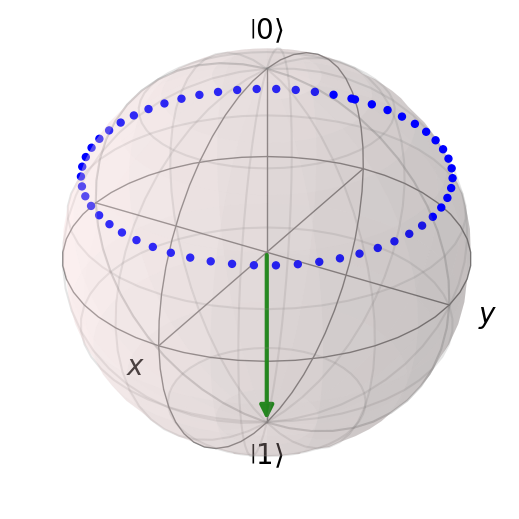

In [36]:
E1 = 0; E2 = 0.1; V = 0.1; H = Hamiltonian_TLS(E1, E2, V); dt = 0.5; t_list = np.arange(0, 28+dt, dt)
sphere = Bloch()
D, W = np.linalg.eigh(H)
D = Qobj(np.diag(D))
W = Qobj(W)
result = sesolve(D, basis(2, 0).transform(W), t_list, e_ops=[sigmax(), sigmay(), sigmaz()])
sx, sy, sz = result.expect[0], result.expect[1], result.expect[2]
sphere.add_points([sx, sy, sz])
sphere.add_vectors([0., 0., -1.])
sphere.show()

If you want to produce an animated gif run the following code.

In [35]:
sphere = Bloch()
for i in range(len(sx)):
    sphere.clear()
    for j in range(i+1):
        sphere.add_points([sx[j], sy[j], sz[j]], alpha=np.exp((j-i)/15))
    sphere.add_vectors([0., 0., -1.])
    sphere.point_color ='b'; sphere.point_marker = 'o'; sphere.point_size = [25]
    sphere.make_sphere()
    sphere.save(name=r'temp_eig_bloch\eig_bloch_{}.png'.format(str(i).zfill(len(str(len(sx))))), dirc=r'temp_eig_bloch')

filenames = [join('temp_eig_bloch', filename) for filename in listdir('temp_eig_bloch') if isfile(join('temp_eig_bloch', filename))]
with imageio.get_writer('Images\movie_eig_bloch.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
shutil.rmtree('temp_eig_bloch')

<div>
<img src="Images\Mission alpha\movie_eig_bloch.gif" width="500"/>
</div>

For a diagonalizable Hamiltonian
$$ H W = W \Lambda $$
where $W$ is the eigenvector matrix and $\Lambda = $ `np.diag` $(D)$ is the eigenvalue matrix.

To change from the original basis to the eigenbasis, you use
$$ \Lambda = W^\dagger H W $$
$$ \left| \phi \right\rangle = W^\dagger \left| \psi \right\rangle $$
while to go back to the original basis, you use
$$ H = W \Lambda W^\dagger $$
$$ \left| \psi \right\rangle = W \left| \phi \right\rangle $$

**Changing the basis set** is a **unitary** transformation that corresponds to a **rotation** of the system (or of the Bloch sphere).

When you change to the eigenbasis, the system dynamics is a phase dynamics: the state of the system precedes along the z-axis.

This is equivalent to say that the populations of the states remain constant, while the coherences oscillates (with a frequancy given by the difference of the eigenvalues).

An important observation is that the precession axis always points in the direction of the eigenstates.

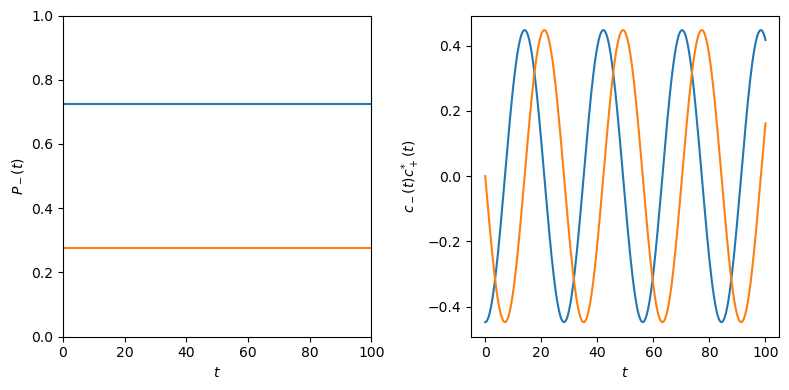

In [20]:
t_list = np.arange(0, 100+dt, dt)

psi_expm = Schrodinger_expm(psi, H, t_list)

# Rotation to the eigenbasis
D, W = np.linalg.eigh(H)
phi = np.zeros_like(psi_expm)
for n in range(psi_expm.shape[1]):
    phi[:,n] = np.conj(W.T) @ psi_expm[:,n]
    
# Plotting Populations and Coherences in the eigenbasis
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(t_list, np.abs(phi[0,:])**2); ax1.plot(t_list, np.abs(phi[1,:])**2)
ax1.set_xlabel(r'$t$'); ax1.set_ylabel(r'$P(t)$');
ax1.set_ylim(0,1); ax1.set_xlim(min(t_list),max(t_list));
ax2.plot(t_list, np.real(phi[0,:] * np.conj(phi[1,:])))
ax2.plot(t_list, np.imag(phi[0,:] * np.conj(phi[1,:])))
ax2.set_xlabel(r'$t$'); ax2.set_ylabel(r'$c_-(t) c^{*}_+(t)$');
fig.tight_layout(); fig.set_size_inches(8,4); fig.set_dpi(100)